In [1]:
!pip install pandas pillow

In [2]:
!pip install pandas
!pip install opencv-python

In [3]:
!pip install tensorflow==2.12.0
!pip install keras

INFO: pip is looking at multiple versions of jax to determine which version is compatible with other requirements. This could take a while.
INFO: pip is still looking at multiple versions of jax to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 585.9/585.9 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 74.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 67.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 95.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 92.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 440.7/440.7 kB 28.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.6/79.6 MB 21.9 MB/s eta 0:00:00
  Attempting uninstall: wrapt
    Found existing installation: wrapt 1.17.0
    Uninst

In [4]:
!pip install -q datasets

In [5]:
import numpy as np
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import cv2
import os
from tensorflow import keras
import glob as gb
import pandas as pd
from tensorflow.keras.preprocessing import image_dataset_from_directory
# Import RandomFlip and RandomRotation from the preprocessing module
from tensorflow.keras.layers.experimental.preprocessing import RandomFlip, RandomRotation
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPool2D, LeakyReLU

In [6]:
from tensorflow.keras.preprocessing import image_dataset_from_directory

# Set image size for ResNet-50 (224x224)
IMG_SIZE = (224, 224)  # ResNet-50 default resolution
directory = "/kaggle/input/rice-leaf-diseases/Rice Leaf Diseases Dataset From Bangladesh"
BATCH_SIZE = 128

# Load training dataset
train_dataset = image_dataset_from_directory(
    directory,
    shuffle=True,
    labels='inferred',
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,  # Updated for ResNet-50
    validation_split=0.1,
    subset='training',
    color_mode='rgb',
    seed=42
)

# Load validation dataset
validation_dataset = image_dataset_from_directory(
    directory,
    shuffle=True,
    labels='inferred',
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,  # Updated for ResNet-50
    validation_split=0.1,
    subset='validation',
    color_mode='rgb',
    seed=42
)


Found 2791 files belonging to 4 classes.
Using 2512 files for training.
Found 2791 files belonging to 4 classes.
Using 279 files for validation.


In [7]:
class_names = train_dataset.class_names
class_names

['Rice___Brown_Spot', 'Rice___Healthy', 'Rice___Hispa', 'Rice___Leaf_Blast']

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


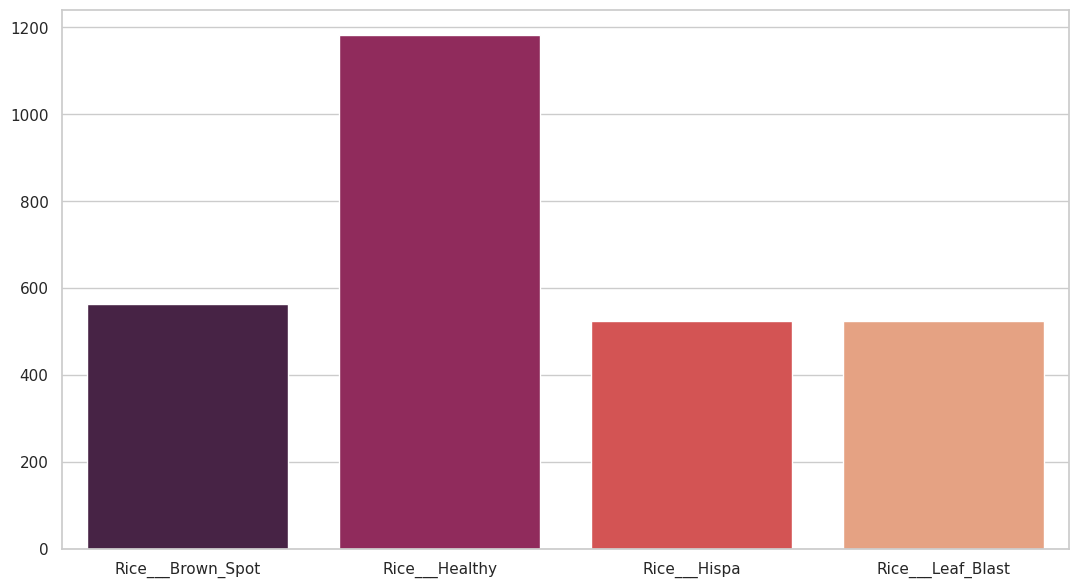

In [8]:
import os
import glob as gb
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="whitegrid")

# Initialize list for storing data imbalance info
Data_imbalance = []

# Loop through each class folder and count the number of images
for folder in os.listdir(directory):
    files = gb.glob(pathname=str(directory + "/" + folder + "/*.*"))
    Data_imbalance.append(len(files))

# Plot data imbalance
plt.figure(figsize=(13, 7))
sns.barplot(
    x=['Rice___Brown_Spot', 'Rice___Healthy', 'Rice___Hispa', 'Rice___Leaf_Blast'], 
    y=Data_imbalance, 
    palette="rocket"
)
plt.show()


In [9]:
total = 0
for i in range(0,len(Data_imbalance)) :
    total +=Data_imbalance[i]

weight_for_0 = (1 / Data_imbalance[0]) * (total / 4.0)
weight_for_1 = (1 / Data_imbalance[1]) * (total / 4.0)
weight_for_2 = (1 / Data_imbalance[2]) * (total / 4.0)
weight_for_3 = (1 / Data_imbalance[3]) * (total / 4.0)

class_weight = {0: weight_for_0, 1: weight_for_1, 2: weight_for_2, 3: weight_for_3}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))
print('Weight for class 2: {:.2f}'.format(weight_for_2))
print('Weight for class 3: {:.2f}'.format(weight_for_3))

Weight for class 0: 1.24
Weight for class 1: 0.59
Weight for class 2: 1.33
Weight for class 3: 1.33


In [10]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip("horizontal"),
  tf.keras.layers.RandomRotation(0.2),
  tf.keras.layers.RandomZoom(0.2),
  tf.keras.layers.RandomHeight(0.2),
  tf.keras.layers.RandomWidth(0.2),
])

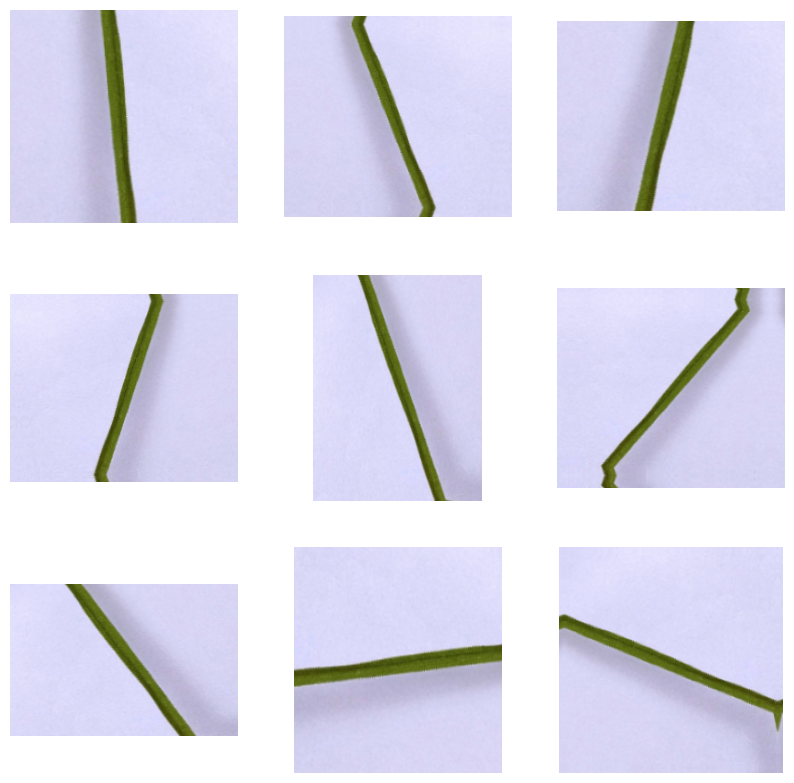

In [11]:
for image, _ in train_dataset.take(1):
    plt.figure(figsize=(10, 10))
    first_image = image[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
        plt.imshow(augmented_image[0] / 255)
        plt.axis('off')

**Rice___Brown_Spott**

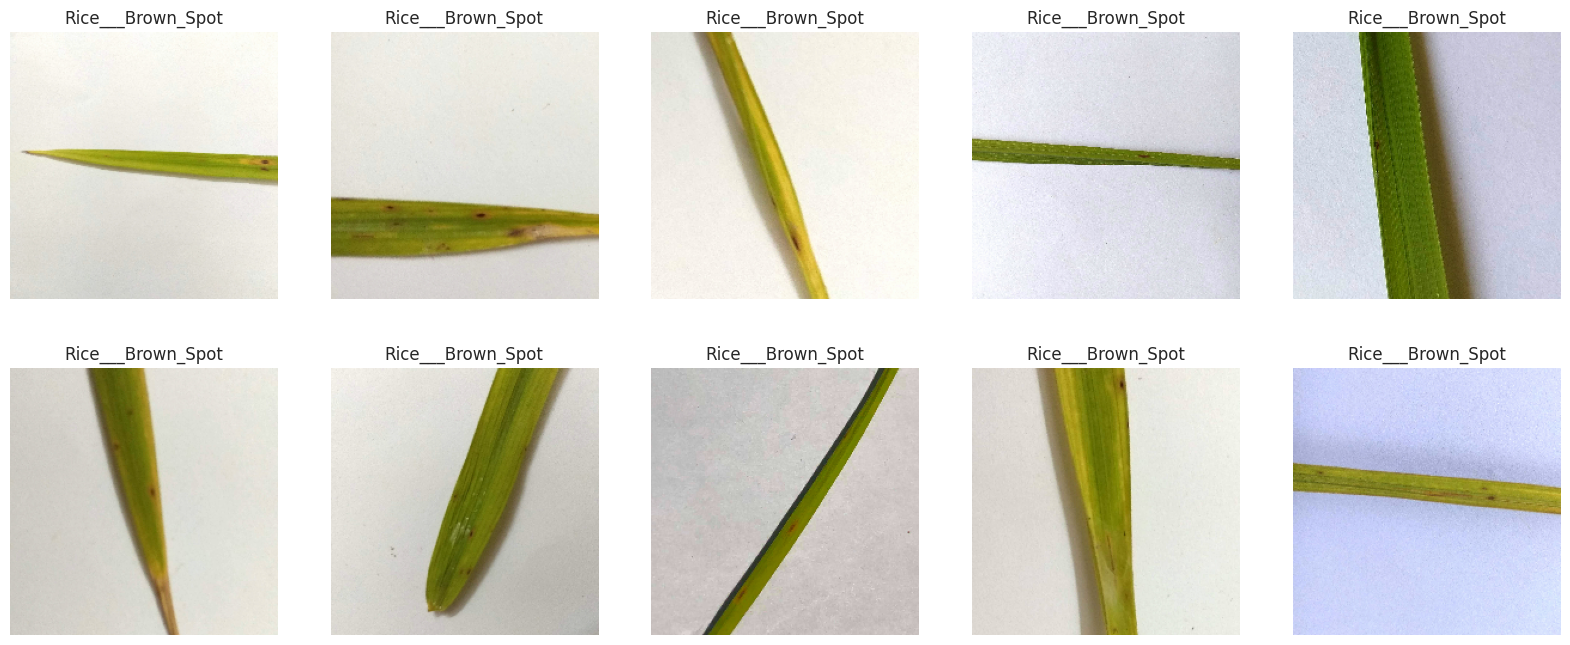

In [12]:
plt.figure(figsize=(20,8))
Rice___Brown_Spot = []
Rice___Hispa= []
Rice___Leaf_Blast =[]


for images , labels in train_dataset.take(1):
    for i in range(100):
        if class_names[labels[i]] == "Rice___Brown_Spot":
            Rice___Brown_Spot.append(images[i].numpy().astype("uint8"))
        if  class_names[labels[i]] == "Rice___Hispa":
            Rice___Hispa.append(images[i].numpy().astype("uint8"))
        if  class_names[labels[i]] == "Rice___Leaf_Blast":
            Rice___Leaf_Blast.append(images[i].numpy().astype("uint8"))

for i in range(10):
    plt.subplot(2,5,i+1)
    plt.imshow(Rice___Brown_Spot[i])
    plt.axis("off")
    plt.title("Rice___Brown_Spot")

**Rice___Hispa**

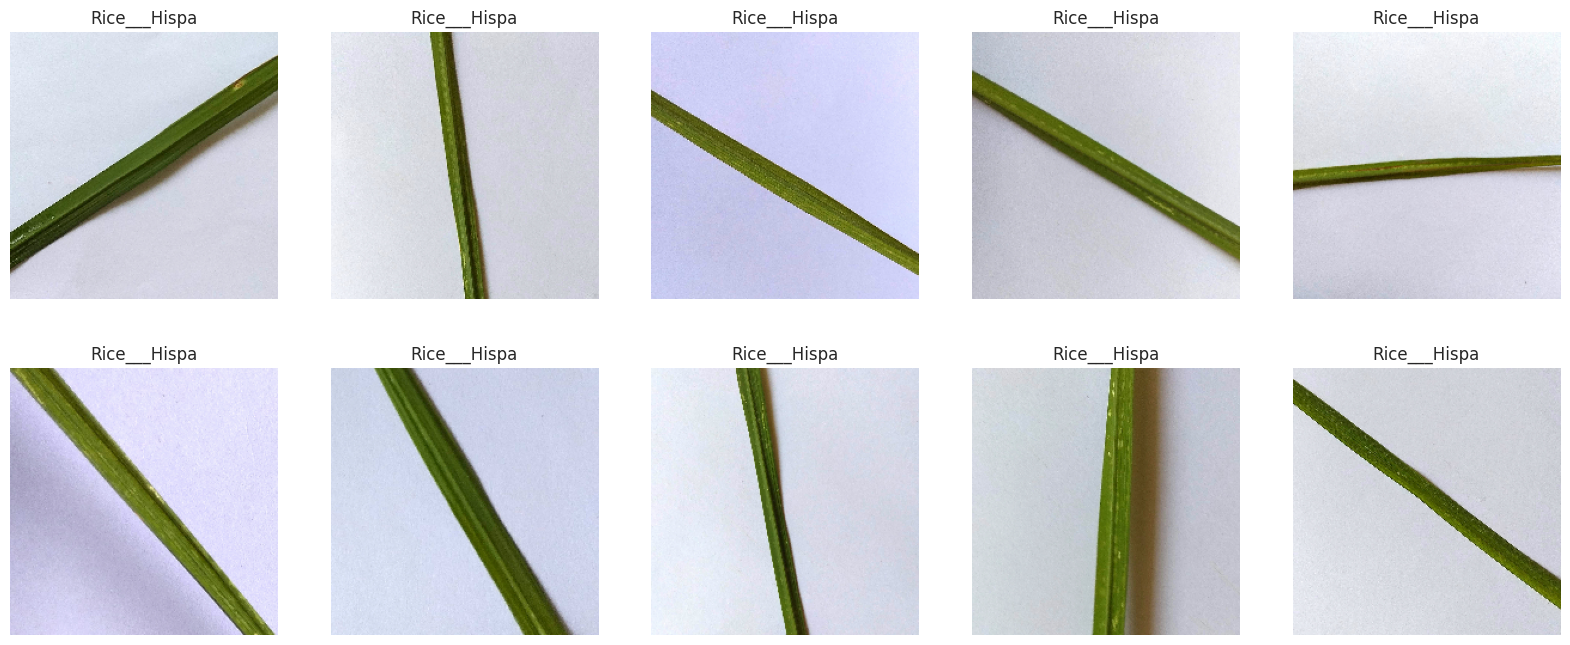

In [13]:
plt.figure(figsize=(20,8))
for i in range(10):
    plt.subplot(2,5,i+1)
    plt.imshow(Rice___Hispa[i])
    plt.axis("off")
    plt.title("Rice___Hispa")

**Rice___Leaf_Blast**

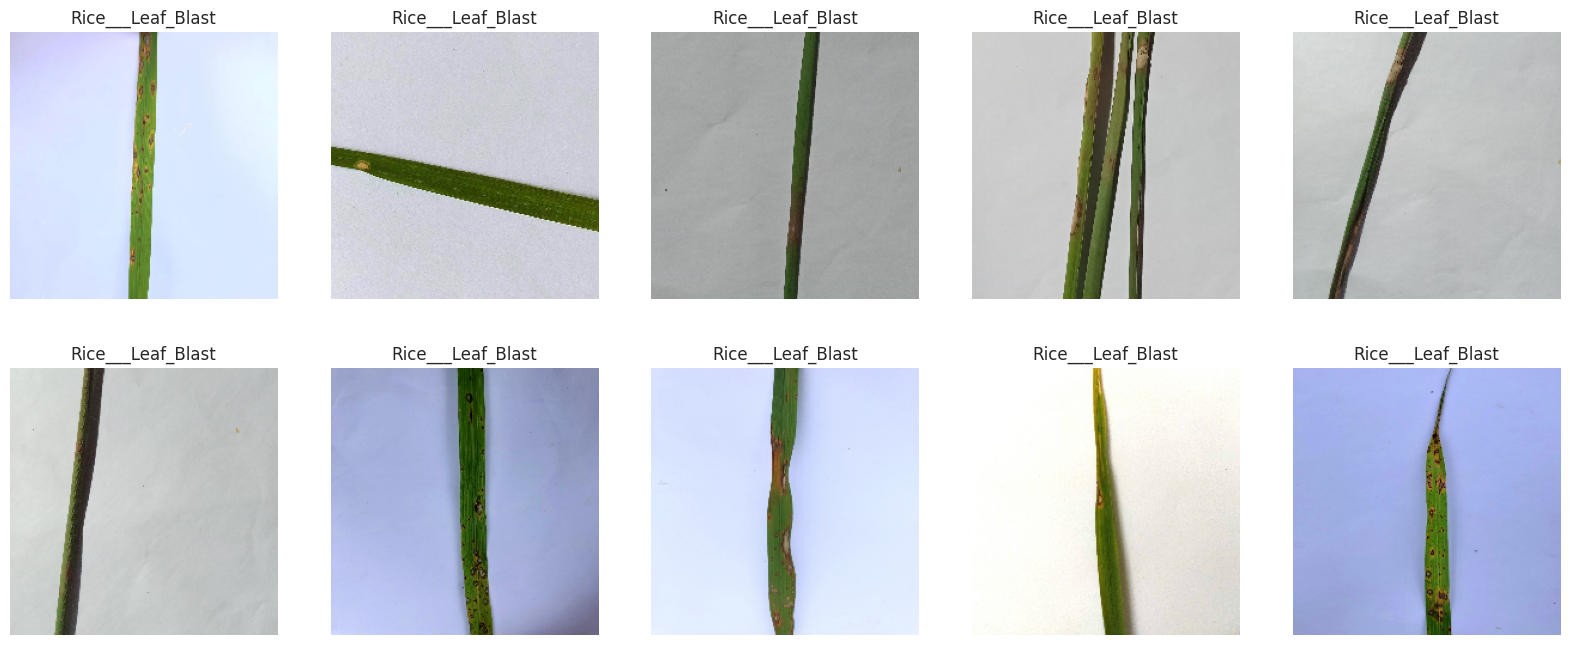

In [14]:

plt.figure(figsize=(20,8))
for i in range(10):
    plt.subplot(2,5,i+1)
    plt.imshow(Rice___Leaf_Blast[i])
    plt.axis("off")
    plt.title("Rice___Leaf_Blast")

In [15]:
import tensorflow as tf

# Enable automatic prefetching for better performance
AUTOTUNE = tf.data.AUTOTUNE  # Updated to tf.data.AUTOTUNE (latest TensorFlow versions)

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)  # Apply to validation dataset too


**MODELING**

In [16]:
import tensorflow as tf

# Define input shape for ResNet-50 (224x224, 3 channels)
IMG_SHAPE = IMG_SIZE + (3,)

# Load ResNet-50 model (pre-trained on ImageNet)
base_model = tf.keras.applications.ResNet50(
    input_shape=IMG_SHAPE,
    include_top=False,  # Exclude fully connected layer for transfer learning
    weights='imagenet'  # Use pre-trained weights
)


94765736/94765736 [==============================] - 4s 0us/step


In [17]:
# Check the type of the base model
type(base_model)

# Set the correct preprocessing function for ResNet50
preprocess_input = tf.keras.applications.resnet50.preprocess_input


In [18]:
# Count the number of layers in ResNet-50
nb_layers = len(base_model.layers)
print("Number of Layers =", nb_layers)

# Print the names of the last two layers
print("Pre-last layer name:", base_model.layers[nb_layers - 2].name)  
print("Last layer name:", base_model.layers[nb_layers - 1].name)


Number of Layers = 175
Pre-last layer name: conv5_block3_add
Last layer name: conv5_block3_out


In [19]:
# Iterate over the first batch (32 images) in the training dataset
image_batch, label_batch = next(iter(train_dataset))  # 32 image arrays

# Extract feature maps using ResNet-50
feature_batch = base_model(image_batch)  # Run images through the base model

# Print the shape of extracted features
print("Feature batch shape:", feature_batch.shape)  


Feature batch shape: (128, 7, 7, 2048)


**ResNet 50**

In [20]:
import tensorflow as tf

def plant_leaf_model(image_shape=IMG_SIZE):
    ''' Define a tf.keras model for multi-class classification using ResNet-50 '''
    image_shape = image_shape + (3,)

    # Load pre-trained ResNet-50 model (without the classification head)
    resnet_model = tf.keras.applications.ResNet50(
        input_shape=image_shape, 
        include_top=False, 
        weights='imagenet'
    )

    # Freeze the initial layers to retain pre-trained features
    resnet_model.trainable = True
    for layer in resnet_model.layers[:143]:  # Fine-tuning from layer 143 onwards
        layer.trainable = False

    # Define the input layer
    inputs = tf.keras.Input(shape=image_shape)
    
    # Data augmentation (if defined)
    x = data_augmentation(inputs)
    
    # Preprocess input for ResNet-50
    x = tf.keras.applications.resnet50.preprocess_input(x)
    
    # Pass through ResNet-50 base model
    x = resnet_model(x, training=False)

    # Global Average Pooling layer
    x = tf.keras.layers.GlobalAveragePooling2D()(x)

    # Dropout to prevent overfitting
    x = tf.keras.layers.Dropout(0.2)(x)

    # Fully connected layer for classification
    prediction_layer = tf.keras.layers.Dense(4, activation="softmax")
    outputs = prediction_layer(x)

    # Define the final model
    model = tf.keras.Model(inputs, outputs)
    
    # Print model summary
    model.summary()
    
    return model


In [21]:
Plant_Leaf_Model = plant_leaf_model(IMG_SIZE)


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, None, None, 3)     0         
                                                                 
 tf.__operators__.getitem (S  (None, None, None, 3)    0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, None, None, 3)    0         
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                      

In [22]:
# Lower learning rate for fine-tuning to avoid destroying pre-trained weights
base_learning_rate = 0.0001  # Reduced from 0.1 to 0.0001 for stability

Plant_Leaf_Model.compile(
    optimizer=tf.keras.optimizers.Nadam(learning_rate=base_learning_rate),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)


In [23]:
history = Plant_Leaf_Model.fit(
    train_dataset,  # Training dataset
    epochs=10,  # Number of epochs
    verbose=2,  # Display progress in a more readable format
    class_weight=class_weight,  # Handle class imbalance (if defined)
    validation_data=validation_dataset,  # Validation dataset
    use_multiprocessing=True,  # Speed up training with multiple processes
    workers=4  # You can increase workers for better data loading performance
)


Epoch 1/10
20/20 - 380s - loss: 1.2033 - accuracy: 0.5044 - val_loss: 0.8968 - val_accuracy: 0.5627 - 380s/epoch - 19s/step
Epoch 2/10
20/20 - 359s - loss: 0.8880 - accuracy: 0.6206 - val_loss: 0.7659 - val_accuracy: 0.6774 - 359s/epoch - 18s/step
Epoch 3/10
20/20 - 365s - loss: 0.7998 - accuracy: 0.6509 - val_loss: 0.7475 - val_accuracy: 0.6738 - 365s/epoch - 18s/step
Epoch 4/10
20/20 - 356s - loss: 0.7262 - accuracy: 0.6947 - val_loss: 0.7972 - val_accuracy: 0.6738 - 356s/epoch - 18s/step
Epoch 5/10
20/20 - 335s - loss: 0.6832 - accuracy: 0.7229 - val_loss: 0.9294 - val_accuracy: 0.6595 - 335s/epoch - 17s/step
Epoch 6/10
20/20 - 353s - loss: 0.6402 - accuracy: 0.7293 - val_loss: 0.8209 - val_accuracy: 0.7133 - 353s/epoch - 18s/step
Epoch 7/10
20/20 - 362s - loss: 0.6248 - accuracy: 0.7337 - val_loss: 0.7023 - val_accuracy: 0.7097 - 362s/epoch - 18s/step
Epoch 8/10
20/20 - 356s - loss: 0.5887 - accuracy: 0.7428 - val_loss: 0.7113 - val_accuracy: 0.7097 - 356s/epoch - 18s/step
Epoch 9/

In [24]:
# Evaluate the model on the validation dataset
validation_loss, validation_accuracy = Plant_Leaf_Model.evaluate(validation_dataset, verbose=1)

# Print the evaluation results
print(f"Validation Loss: {validation_loss}")
print(f"Validation Accuracy: {validation_accuracy}")


3/3 [==============================] - 26s 5s/step - loss: 0.6189 - accuracy: 0.7204
Validation Loss: 0.6189315915107727
Validation Accuracy: 0.7204301357269287


1/1 [==============================] - 0s 87ms/step


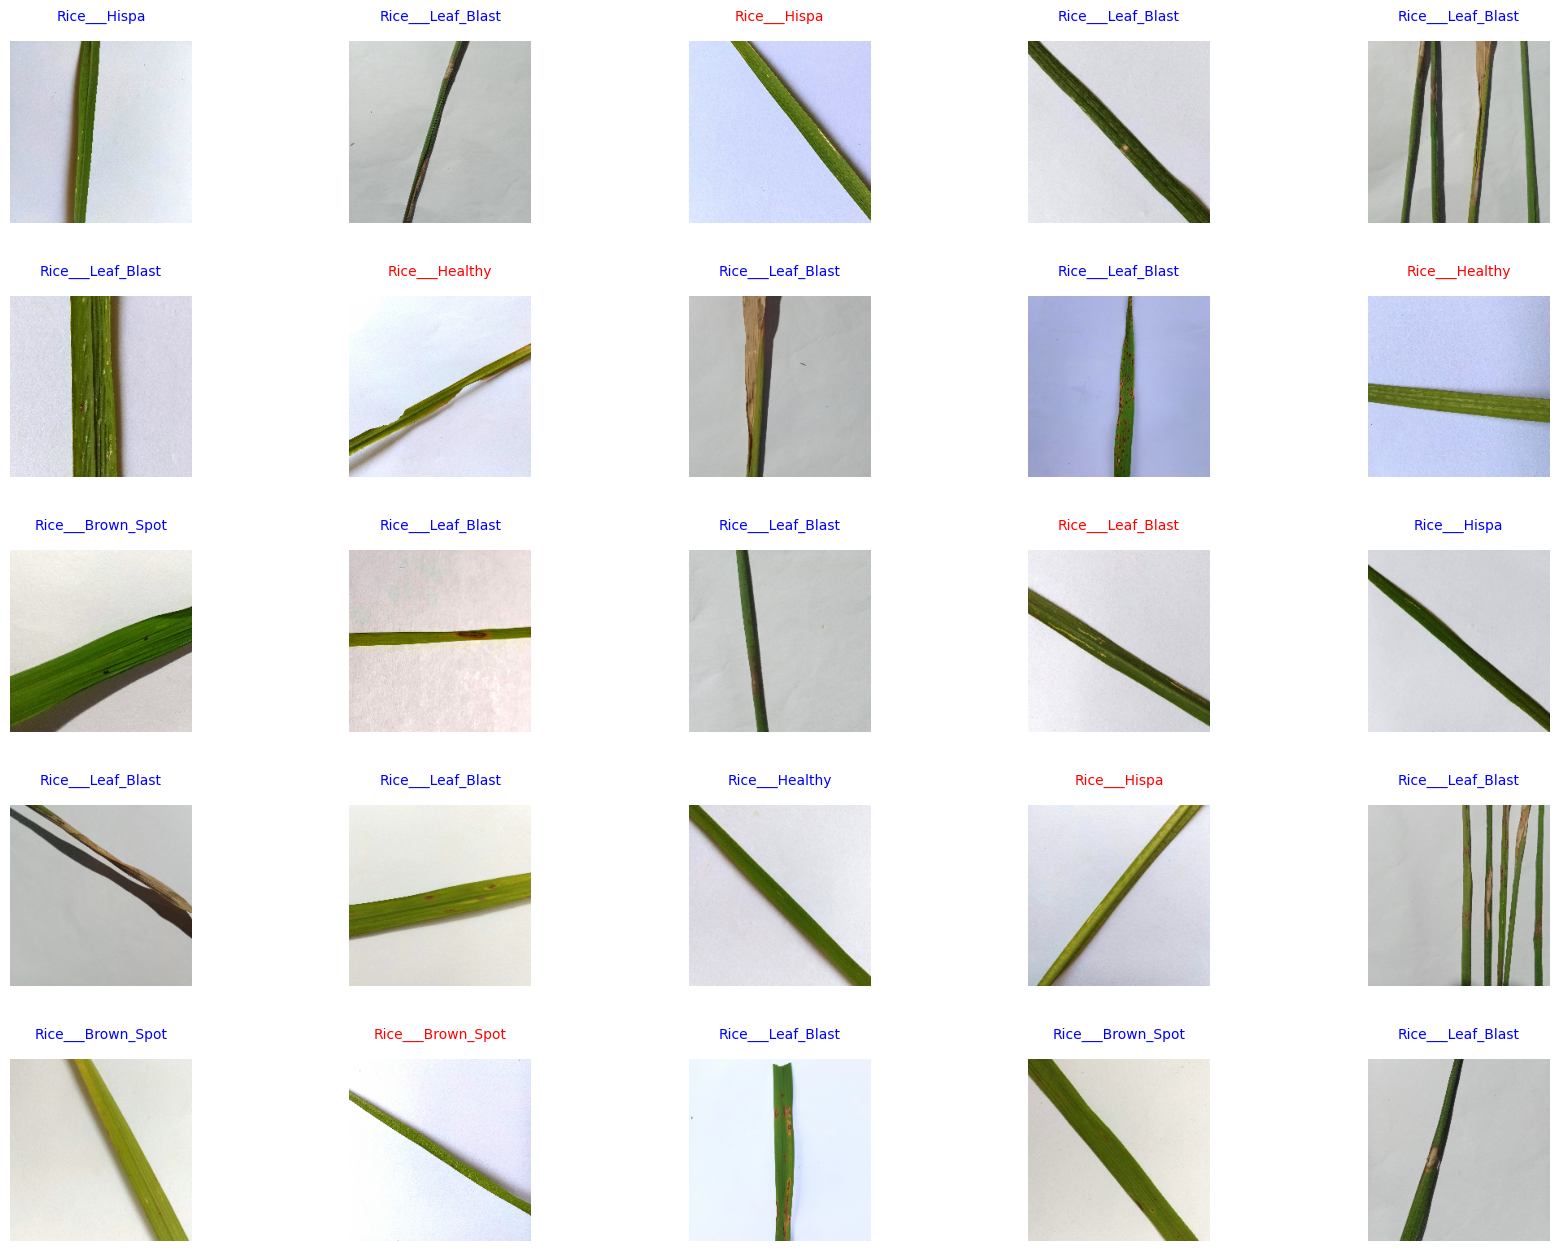

In [25]:
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np

# Visualize predictions for a batch of 25 images
plt.figure(figsize=(20, 15))

for images, labels in train_dataset.take(1):  # Take the first batch from train_dataset
    for i in range(25):  # Loop over the first 25 images in the batch
        plt.subplot(5, 5, i + 1)  # Create a 5x5 grid of subplots
        plt.imshow(images[i].numpy().astype("uint8"))  # Display image
        plt.axis("off")  # Hide axes

        # Predict class for the current image
        im2 = images[i].numpy().astype("uint8")
        img2 = tf.expand_dims(im2, 0)  # Expand dimensions for prediction
        predict = Plant_Leaf_Model.predict(img2)
        predicted = class_names[np.argmax(predict)]  # Get predicted class
        actual = class_names[labels[i].numpy().astype("uint8")]  # Get actual class

        # Display title: blue if correct, red if incorrect
        if actual == predicted:
            plt.title(predicted, fontsize=10, color='blue', pad=15)
        else:
            plt.title(actual, fontsize=10, color='red', pad=15)

    plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.4, hspace=0.4)
    plt.show()


**Plotting Accuracy**

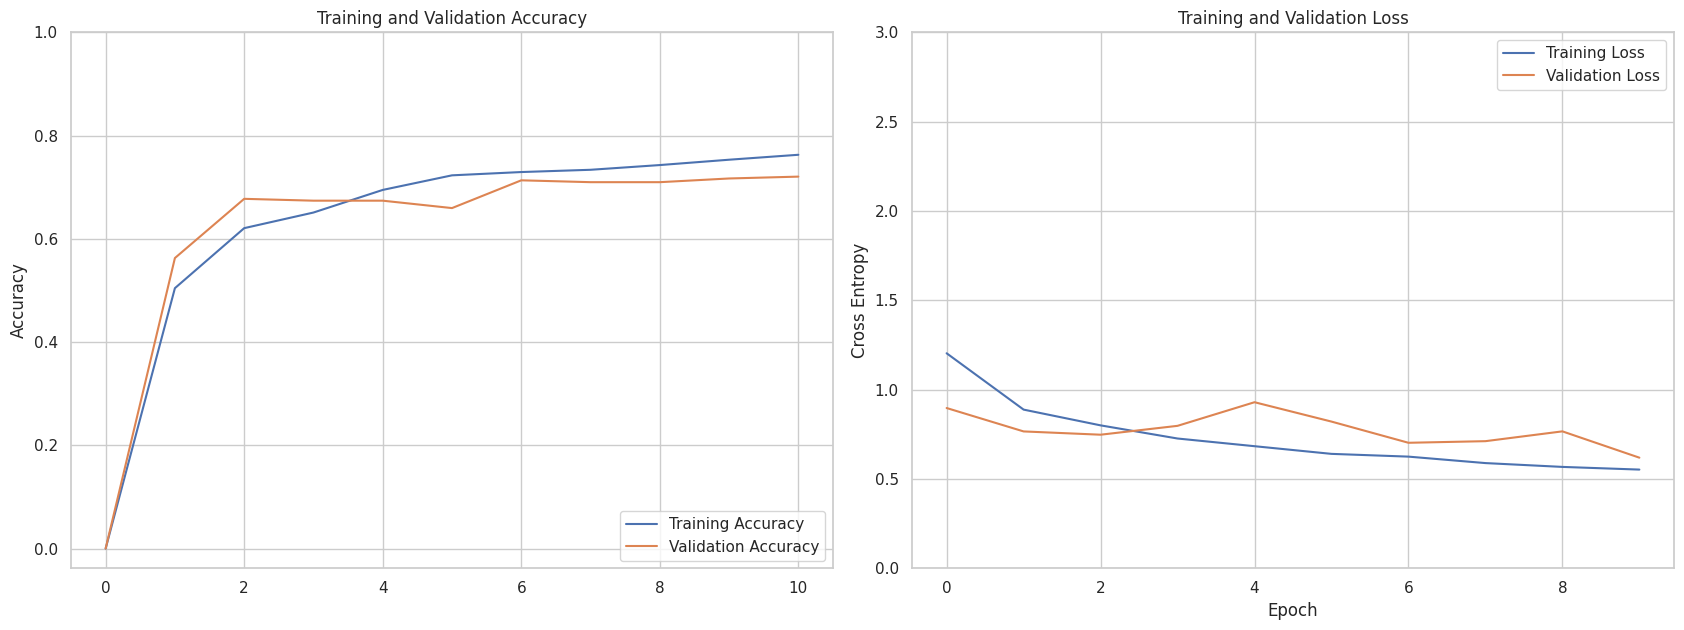

In [26]:
import matplotlib.pyplot as plt

# Extract accuracy and loss values from training history
acc = [0.] + history.history['accuracy']
val_acc = [0.] + history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

# Plotting the graphs
plt.figure(figsize=(17, 12))

# Subplot for Accuracy
plt.subplot(2, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()), 1])  # Y-axis from min value to 1
plt.title('Training and Validation Accuracy')

# Subplot for Loss
plt.subplot(2, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0, 3.0])  # Y-axis range for loss
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')

# Show the plots
plt.tight_layout()  # Adjusts subplots to fit better
plt.show()


1/1 [==============================] - 2s 2s/step


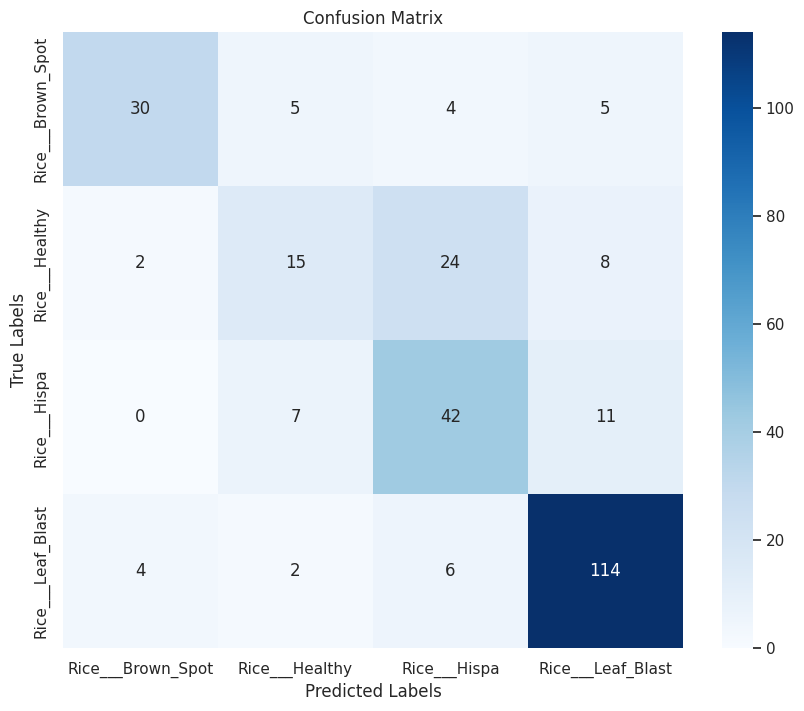

Confusion Matrix:
[[ 30   5   4   5]
 [  2  15  24   8]
 [  0   7  42  11]
 [  4   2   6 114]]
Classification Report:
                   precision    recall  f1-score   support

Rice___Brown_Spot       0.83      0.68      0.75        44
   Rice___Healthy       0.52      0.31      0.38        49
     Rice___Hispa       0.55      0.70      0.62        60
Rice___Leaf_Blast       0.83      0.90      0.86       126

         accuracy                           0.72       279
        macro avg       0.68      0.65      0.65       279
     weighted avg       0.71      0.72      0.71       279



In [27]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Get true labels and predicted labels
true_labels = []
predicted_labels = []

# Loop through the validation dataset to collect true and predicted labels
for images, labels in validation_dataset:
    predictions = Plant_Leaf_Model.predict(images)
    predicted_classes = np.argmax(predictions, axis=1)  # Get the index of the predicted class
    true_labels.extend(labels.numpy())  # Convert tensor to numpy and add to list
    predicted_labels.extend(predicted_classes)  # Add predicted classes to list

# Compute confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Plot confusion matrix using seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# Print confusion matrix separately
print("Confusion Matrix:")
print(conf_matrix)

# Generate and print classification report
report = classification_report(true_labels, predicted_labels, target_names=class_names)
print("Classification Report:")
print(report)


In [28]:
# Print classification report separately
print("Classification Report:")
report = classification_report(true_labels, predicted_labels, target_names=class_names)
print(report)


Classification Report:
                   precision    recall  f1-score   support

Rice___Brown_Spot       0.83      0.68      0.75        44
   Rice___Healthy       0.52      0.31      0.38        49
     Rice___Hispa       0.55      0.70      0.62        60
Rice___Leaf_Blast       0.83      0.90      0.86       126

         accuracy                           0.72       279
        macro avg       0.68      0.65      0.65       279
     weighted avg       0.71      0.72      0.71       279

